## Initialize and Import Vensim Files

In [47]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.optimize


import pysd
import pysd.translators.vensim.vensim_file
import matplotlib.pyplot as plt

In [48]:
#read mdl file, converts it into python
model = pysd.read_vensim('Vensim/ClimateModule_NaturalEmissions.mdl')

#load existing py file
model = pysd.load('Vensim/ClimateModule_NaturalEmissions.py')

In [49]:
# Check all variables with the word 'forcing' in them
#model.doc[model.doc['Real Name'].str.contains('forcing', case=False)]

## Testing PySD Capabilities

In [50]:
def extract_column(var_name, column_name):
    return model.doc.loc[model.doc['Real Name'] == var_name, column_name].values[0]

extract_column('CH4 Radiative Forcing New', 'Units')

'W/(m*m)'

c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


<Axes: xlabel='time'>

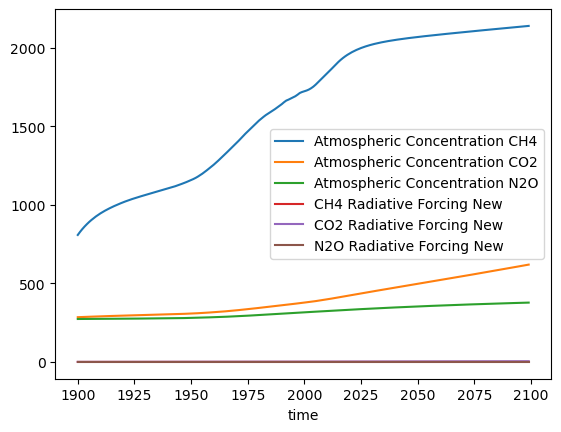

In [51]:
# run model
testrun = model.run(params={},
                   return_columns=['Atmospheric Concentration CH4',
                                   'Atmospheric Concentration CO2',
                                   'Atmospheric Concentration N2O',
                                   'CH4 Radiative Forcing New',
                                   'CO2 Radiative Forcing New',
                                   'N2O Radiative Forcing New'],
                   return_timestamps = np.arange(1900, 2100, 1))


# Sample Plot
testrun.plot()
#plt.plot(testrun.index, testrun['Atmospheric Concentration CH4'], label='Simulated')
#plt.ylabel(extract_column('Atmospheric Concentration CH4', 'Units'))
#plt.xlabel('Years')
#plt.title(extract_column('Atmospheric Concentration CH4', 'Real Name'))
#plt.legend(loc='lower right')

## Prepare Scenario RCMIP Scenario Inputs

In [52]:
# Some data has intervals, some has cut offs

emis_df = pd.read_csv('Vensim_Runs/inputs_emissions.csv')
emis_df[emis_df['Variable'] == 'Emissions|CH4'].head()

,Model,Scenario,Region,Variable,Unit,1900,1901,1902,1903,1904,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,AIM,rcp60,World,Emissions|CH4,Mt CH4/yr,123.739050,124.841500,125.943960,127.046420,128.148870,...,267.60942,265.20564,262.80186,260.39808,257.9943,255.59052,253.18674,250.78296,248.37918,245.975400
3,AIM/CGE,ssp370,World,Emissions|CH4,Mt CH4/yr,87.613288,88.391167,89.262825,89.890741,91.356749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.732192
6,AIM/CGE,ssp370-lowNTCF-aerchemmip,World,Emissions|CH4,Mt CH4/yr,87.613288,88.391167,89.262825,89.890741,91.356749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.732192
9,AIM/CGE,ssp370-lowNTCF-gidden,World,Emissions|CH4,Mt CH4/yr,87.613288,88.391167,89.262825,89.890741,91.356749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.621326
12,CEDS/UVA/GCP/PRIMAP,historical,World,Emissions|CH4,Mt CH4/yr,87.613288,88.391167,89.262825,89.890741,91.356749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Show Scenario Types
emis_df['Scenario'].unique()

array(['rcp60', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
       'ssp370-lowNTCF-gidden', 'historical', 'ssp434', 'ssp460', 'rcp26',
       'ssp119', 'ssp126', 'rcp85', 'ssp245', 'rcp45', 'ssp534-over',
       'ssp585', 'esm-bell-1000PgC', 'esm-bell-2000PgC',
       'esm-bell-750PgC', 'esm-pi-CO2pulse', 'esm-pi-cdr-pulse',
       'esm-piControl', 'historical-cmip5'], dtype=object)

In [54]:
def get_var_scenario(variable, scenario):
    # Get the row for the given variable and scenario
    row = emis_df[(emis_df['Variable'] == variable) & (emis_df['Scenario'] == scenario)].iloc[0]
    # Extract only the year columns (which are digits)
    year_cols = [col for col in row.index if col.isdigit()]
    # Convert year columns to int for sorting and ensure all years are present
    years = sorted([int(y) for y in year_cols])
    # Create a full range of years from min to max
    full_years = np.arange(min(years), max(years)+1)
    # Extract the values for the year columns and convert to float
    values = row[year_cols].astype(np.float64)
    # Create a Series with years as integer index
    series = pd.Series(values.values, index=[int(y) for y in year_cols], dtype=np.float64)
    # Reindex to include all years, introducing NaNs for missing years
    series = series.reindex(full_years)
    # Interpolate missing years linearly
    series = series.interpolate(method='linear', limit_direction='backward')
    # Optionally, set the name for the series
    series.name = f"{variable}_{scenario}"
    return series.astype(np.float64)


#print(get_var_scenario("Emissions|N2O","historical"))
print(get_var_scenario("Emissions|N2O","ssp370-lowNTCF-gidden"))

#pd.DataFrame(get_row("Emissions|CH4","rcp60"))

1900     1356.162960
1901     1369.103372
1902     1384.515481
1903     1399.355378
1904     1415.597756
            ...     
2096    20296.524020
2097    20399.503390
2098    20502.482760
2099    20605.462130
2100    20708.441500
Name: Emissions|N2O_ssp370-lowNTCF-gidden, Length: 201, dtype: float64


## Run All Scenarios and Export Outputs in RCMIP Format

### Mapping FeliX Names to RCMIP Names (to Define Model Output Variables of Interest)

In [55]:
# Create mapping dictionaries for Variable names (FeliX to RCMIP)

FeliX_RCMIP_Dict_df= pd.read_csv('Vensim_Runs/FeliX_RCMIP_VarMapping.csv')

feliX_var_dict = dict(zip(FeliX_RCMIP_Dict_df['FeliX_Var_Name'], FeliX_RCMIP_Dict_df['Variable']))

### Function for Running Scenarios

In [67]:
# Function to Define what Scenarios to Run based on a fixed set of Inputs/Outputs

def run_scenario(s, return_columns):
    # Running One Scenario Instance. Inputs: Emissions (Fixed), Outputs: Conc + Forcing
    stock = model.run(params={
        'Total CO2 Emissions': get_var_scenario("Emissions|CO2", s),
        'Total CH4 Emissions': get_var_scenario("Emissions|CH4", s),
        'Total N2O Emissions': get_var_scenario("Emissions|N2O", s)
    },
    return_columns=return_columns,
    return_timestamps=np.arange(1900, 2101, 1))
    
    s_output = stock.transpose()
    
    # Add metadata columns to the front of the DataFrame
    # Get metadata from emis_df for RCMIP scenario data
    scenario_metadata = emis_df[emis_df['Scenario'] == s].iloc[0]

    # Get units from PySD model for each variable
    def get_unit_from_pysd(var_name):
        try:
            return extract_column(var_name, 'Units')
        except:
            return var_name  # Return variable name if unit not found

    # Create the metadata columns with standardized names and units
    metadata_df = pd.DataFrame({
        'Model': [scenario_metadata['Model']] * len(s_output),
        'Scenario': [s] * len(s_output),
        'Region': [scenario_metadata['Region']] * len(s_output),
        'Variable': [feliX_var_dict.get(var, var) for var in s_output.index],  # Map to RCMIP names
        'FeliX_Unit': [get_unit_from_pysd(var) for var in s_output.index],  # Get units from PySD
        'Unit': [FeliX_RCMIP_Dict_df.loc[FeliX_RCMIP_Dict_df['FeliX_Var_Name'] == var, 'Unit'].values[0] if not FeliX_RCMIP_Dict_df.loc[FeliX_RCMIP_Dict_df['FeliX_Var_Name'] == var, 'Unit'].empty else None for var in s_output.index],  # Get units from FeliX_RCMIP_Dict_df
        'ClimateModel': ['FeliX'] * len(s_output)  # Fixed value as requested
    })

    # Combine metadata columns with the data
    final_output = pd.concat([metadata_df, s_output.reset_index(drop=True)], axis=1)
    return final_output

# Check if interpolation works
# result = run_scenario("ssp370-lowNTCF-gidden", 
#                       params={'Total CO2 Emissions': get_var_scenario("Emissions|CO2", "ssp370-lowNTCF-gidden"),
#                               'Total CH4 Emissions': get_var_scenario("Emissions|CH4", "ssp370-lowNTCF-gidden"),
#                               'Total N2O Emissions': get_var_scenario("Emissions|N2O", "ssp370-lowNTCF-gidden")},
#                       return_columns=['Atmospheric Concentration CH4',
#                                       'Atmospheric Concentration CO2',
#                                       'Atmospheric Concentration N2O',
#                                       'CH4 Radiative Forcing New',
#                                       'CO2 Radiative Forcing New',
#                                       'N2O Radiative Forcing New'])

In [ ]:
outputset = list(feliX_var_dict.keys())
#outputset

results = run_scenario(
    s = "rcp60", 
    return_columns  outputset
)
results.head()

c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


,Model,Scenario,Region,Variable,FeliX_Unit,Unit,ClimateModel,1900.0,1901.0,1902.0,...,2091.0,2092.0,2093.0,2094.0,2095.0,2096.0,2097.0,2098.0,2099.0,2100.0
0,AIM,rcp60,World,Atmospheric Concentrations|CH4,ppb,ppb,FeliX,808.000000,839.716248,868.552340,...,1880.215837,1866.662008,1853.877013,1841.781408,1830.303882,1819.380415,1808.953521,1798.971576,1789.388215,1780.161792
1,AIM,rcp60,World,Atmospheric Concentrations|CO2,ppm,ppm,FeliX,284.700000,285.133226,285.684443,...,650.080617,653.457632,656.826941,660.187874,663.539940,666.882716,670.215825,673.538924,676.851702,680.153877
2,AIM,rcp60,World,Atmospheric Concentrations|N2O,ppb,ppb,FeliX,273.200000,273.287355,273.376681,...,424.268779,425.362548,426.445200,427.516831,428.577534,429.627402,430.666528,431.695003,432.712918,433.720362
3,AIM,rcp60,World,Net Land to Atmosphere Flux|CH4,MTonCH4/Year,Mt CH4/yr,FeliX,340.533604,341.647483,342.759219,...,534.485453,532.636064,530.785020,528.932285,527.077791,525.221446,523.363144,521.502773,519.640219,517.775370
4,AIM,rcp60,World,Net Land to Atmosphere Flux|CO2,MTonCO2/Year,Mt CO2/yr,FeliX,0.000000,-184.305075,-402.774573,...,-16813.681875,-16667.630393,-16525.197839,-16386.038713,-16249.864970,-16116.423819,-15985.490895,-15856.866494,-15730.372654,-15605.850665


### Actual Runs

In [ ]:
scenarios = emis_df['Scenario'].unique()
FeliX_RCMIP_Results = pd.DataFrame()

# Run All Scenarios
for scenario in scenarios:
    scenario_result = run_scenario(s = scenario, 
                                   return_columns = outputset)  # Fixed syntax by removing the colon
    print(scenario)
    FeliX_RCMIP_Results = pd.concat([FeliX_RCMIP_Results, scenario_result], ignore_index=True)

c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


rcp60


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp370


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp370-lowNTCF-aerchemmip


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp370-lowNTCF-gidden


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


historical


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp434


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp460


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


rcp26


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp119


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp126


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


rcp85


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp245


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


rcp45


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp534-over


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


ssp585


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


esm-bell-1000PgC


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


esm-bell-2000PgC


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


esm-bell-750PgC


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


esm-pi-CO2pulse


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


esm-pi-cdr-pulse


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


esm-piControl


c:\Users\tanryan\AppData\Local\anaconda3\Lib\site-packages\pysd\py_backend\lookups.py:96: UserWarning: _hardcodedlookup_table_other_anthropogenic_radiative_forcing
extrapolating data above the maximum value of the series
  warnings.warn(


historical-cmip5


In [71]:
FeliX_RCMIP_Results.to_csv('Vensim_Runs/FeliX_Outputs_All.csv', index=False)
